In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [2]:
def multiply_and_resample(x, y, seed = None):

    rng = np.random.default_rng(seed)

    xg, yg = np.atleast_2d(x, y)

    xy = (xg.T @ yg).flatten()

    return rng.choice(xy, size = x.shape, replace = False)

In [3]:
from scipy.special import factorial

def queuing_time(l, m, c):

    rho = l / (c * m)

    k = np.arange(0, c, 1)

    p_0 = 1 / (
        sum([(c * rho) ** k / factorial(k) for k in k]) +
        (c * rho) ** c / (factorial(c) * (1 - rho))
    )

    l_q = (p_0 * (l / m) ** c * rho) / (factorial(c) * (1 - rho))

    w_q = l_q / l

    return w_q

In [4]:
from scipy.special import factorial

def station_time(l, m, c):

    rho = l / (c * m)

    k = np.arange(0, c, 1)

    p_0 = 1 / (
        sum([(c * rho) ** k / factorial(k) for k in k]) +
        (c * rho) ** c / (factorial(c) * (1 - rho))
    )

    l_q = (p_0 * (l / m) ** c * rho) / (factorial(c) * (1 - rho))

    w_q = l_q / l + 1 / m

    return w_q

In [5]:
def plot_histogram(x, ax, bins = 50, **kwargs):

    values, bins = np.histogram(x, bins = bins)
    
    ub = rv_histogram((values, bins)).ppf([.5, .75, .99])
    
    width = bins[1] - bins[0]
    locations = bins[:-1] + width / 2
    ax.bar(locations, values / len(qte), width = .8 * width, **kwargs)

    ylim = ax.get_ylim()
    
    ax.plot([ub[0], ub[0]], ylim, color = 'k', lw = 2, ls = '-.',
            label = '50th Percentile')
    ax.plot([ub[1], ub[1]], ylim, color = 'k', lw = 2, ls = '--',
            label = '75th Percentile')
    ax.plot([ub[2], ub[2]], ylim, color = 'k', lw = 2, ls = ':',
            label = '99th Percentile')

    ax.set_ylim(ylim)
    ax.set_xlim([bins[0] * .95, ub[2] * 1.05])

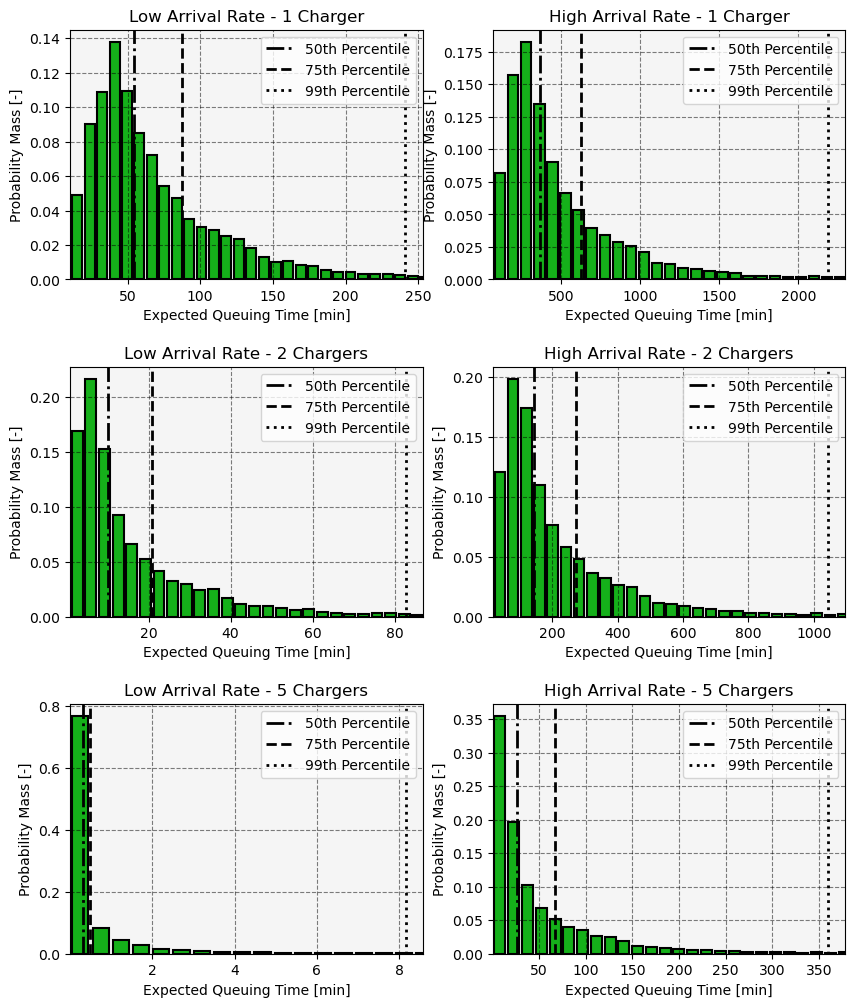

In [17]:
from scipy.stats import norm, uniform, rv_histogram

shape = (100, )
seed = 14285963

axes_kwargs = {
    'facecolor': 'whitesmoke',
    'xlabel': 'Expected Queuing Time [min]',
    'ylabel': 'Probability Mass [-]',
}

grid_kwargs = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .5,
}

legend_kwargs = {
    'loc': 1,
}

bar_kwargs = {
    'color': 'xkcd:green',
    'ec': '#000000',
    # 'fc': '#2a8665',
    'lw': 1.5,
}

fig, ax = plt.subplots(3, 2, figsize = (10, 12), gridspec_kw = {'hspace': .35})

arrival_dist = uniform(loc = 600, scale = 3600)
arrival_frequency = 1 / arrival_dist.rvs(size = shape, random_state = seed)

charge_energy_dist = norm(loc = 60 * 3.6e6, scale = 15 * 3.6e6)
charge_energy = np.clip(
    charge_energy_dist.rvs(size = shape, random_state = seed), 10 * 3.6e6, 100 * 3.6e6
)

charge_rates_dist = rv_histogram([[1], [80e3, 80e3]])
charge_rates = charge_rates_dist.rvs(size = shape, random_state = seed)

service_times = multiply_and_resample(charge_energy, 1/charge_rates, seed = seed)
service_frequency = 1 / service_times

afg, sfg = np.meshgrid(arrival_frequency, service_frequency, indexing  = 'ij')

n_servicers = 1
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[0, 0], **bar_kwargs)
ax[0, 0].set_title('Low Arrival Rate - 1 Charger')

n_servicers = 2
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[1, 0], **bar_kwargs)
ax[1, 0].set_title('Low Arrival Rate - 2 Chargers')

n_servicers = 5
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[2, 0], **bar_kwargs)
ax[2, 0].set_title('Low Arrival Rate - 5 Chargers')

arrival_dist = uniform(loc = 60, scale = 600)
arrival_frequency = 1 / arrival_dist.rvs(size = shape, random_state = seed)

charge_energy_dist = norm(loc = 60 * 3.6e6, scale = 15 * 3.6e6)
charge_energy = np.clip(
    charge_energy_dist.rvs(size = shape, random_state = seed), 10 * 3.6e6, 100 * 3.6e6
)

charge_rates_dist = rv_histogram([[1], [80e3, 80e3]])
charge_rates = charge_rates_dist.rvs(size = shape, random_state = seed)

service_times = multiply_and_resample(charge_energy, 1/charge_rates, seed = seed)
service_frequency = 1 / service_times

afg, sfg = np.meshgrid(arrival_frequency, service_frequency, indexing  = 'ij')

n_servicers = 1
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[0, 1], **bar_kwargs)
ax[0, 1].set_title('High Arrival Rate - 1 Charger')

n_servicers = 2
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[1, 1], **bar_kwargs)
ax[1, 1].set_title('High Arrival Rate - 2 Chargers')

n_servicers = 5
qte = queuing_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[2, 1], **bar_kwargs)
ax[2, 1].set_title('High Arrival Rate - 5 Chargers')

_ = [ax.set(**axes_kwargs) for ax in ax for ax in ax]
_ = [ax.grid(**grid_kwargs) for ax in ax for ax in ax]
_ = [ax.legend(**legend_kwargs) for ax in ax for ax in ax]

fig.savefig('Paper/figs/expected_delay.png', dpi = 300, bbox_inches = 'tight')

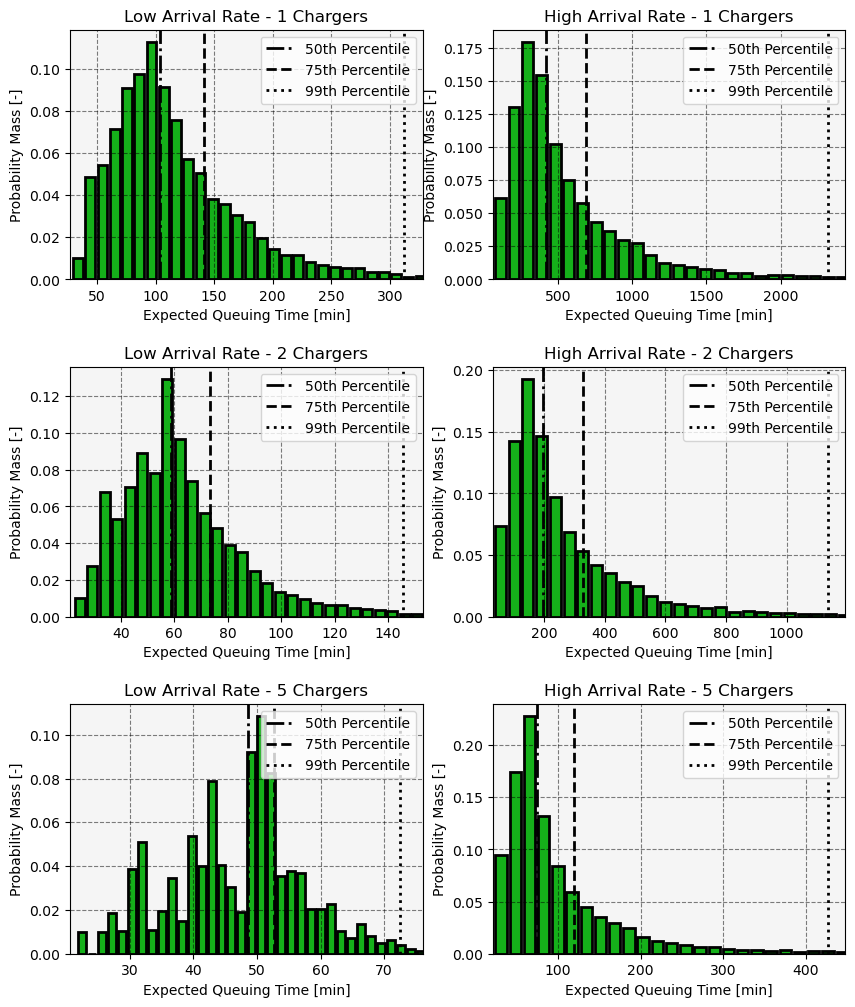

In [33]:
shape = (100, )
seed = 14285963

axes_kwargs = {
    'facecolor': 'whitesmoke',
    'xlabel': 'Expected Queuing Time [min]',
    'ylabel': 'Probability Mass [-]',
}

grid_kwargs = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .5,
}

legend_kwargs = {
    'loc': 1,
}

bar_kwargs = {
    'color': 'xkcd:green',
    'ec': 'k',
    'lw': 2,
}

fig, ax = plt.subplots(3, 2, figsize = (10, 12), gridspec_kw = {'hspace': .35})

arrival_dist = uniform(loc = 600, scale = 3600)
arrival_frequency = 1 / arrival_dist.rvs(size = shape, random_state = seed)

charge_energy_dist = norm(loc = 60 * 3.6e6, scale = 15 * 3.6e6)
charge_energy = np.clip(
    charge_energy_dist.rvs(size = shape, random_state = seed), 10 * 3.6e6, 100 * 3.6e6
)

charge_rates_dist = rv_histogram([[1], [80e3, 80e3]])
charge_rates = charge_rates_dist.rvs(size = shape, random_state = seed)

service_times = multiply_and_resample(charge_energy, 1/charge_rates, seed = seed)
service_frequency = 1 / service_times

afg, sfg = np.meshgrid(arrival_frequency, service_frequency, indexing  = 'ij')

n_servicers = 1
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[0, 0], **bar_kwargs)
ax[0, 0].set_title('Low Arrival Rate - 1 Charger')

n_servicers = 2
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[1, 0], **bar_kwargs)
ax[1, 0].set_title('Low Arrival Rate - 2 Chargers')

n_servicers = 5
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[2, 0], **bar_kwargs)
ax[2, 0].set_title('Low Arrival Rate - 5 Chargers')

arrival_dist = uniform(loc = 60, scale = 600)
arrival_frequency = 1 / arrival_dist.rvs(size = shape, random_state = seed)

charge_energy_dist = norm(loc = 60 * 3.6e6, scale = 15 * 3.6e6)
charge_energy = np.clip(
    charge_energy_dist.rvs(size = shape, random_state = seed), 10 * 3.6e6, 100 * 3.6e6
)

charge_rates_dist = rv_histogram([[1], [80e3, 80e3]])
charge_rates = charge_rates_dist.rvs(size = shape, random_state = seed)

service_times = multiply_and_resample(charge_energy, 1/charge_rates, seed = seed)
service_frequency = 1 / service_times

afg, sfg = np.meshgrid(arrival_frequency, service_frequency, indexing  = 'ij')

n_servicers = 1
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[0, 1], **bar_kwargs)
ax[0, 1].set_title('High Arrival Rate - 1 Charger')

n_servicers = 2
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[1, 1], **bar_kwargs)
ax[1, 1].set_title('High Arrival Rate - 2 Chargers')

n_servicers = 5
qte = station_time(afg.flatten(), sfg.flatten(), n_servicers)
plot_histogram(qte / 60, ax[2, 1], **bar_kwargs)
ax[2, 1].set_title('High Arrival Rate - 5 Chargers')

_ = [ax.set(**axes_kwargs) for ax in ax for ax in ax]
_ = [ax.grid(**grid_kwargs) for ax in ax for ax in ax]
_ = [ax.legend(**legend_kwargs) for ax in ax for ax in ax]